In [1]:
from __future__ import print_function, division, absolute_import

In [82]:
from joblib import Parallel, delayed  # for parallel processes
import tarfile
import nltk
from gensim.models.phrases import Phraser, Phrases
import re # for preprocessing the corpus

import os
import codecs
import pickle
import time


import tensorflow as tf
import numpy as np

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Data Preprocessing

In [5]:
tar = tarfile.open("../../NLP_data/parallel/en-fr_small.tar.gz", "r:gz")
files = tar.getmembers()

In [6]:
load_dataset = lambda file: tar.extractfile(file).read().decode("utf-8")

tokenize = lambda text: text.split("\n")

w2id = lambda vocabs, len_special_tokens: dict(
    zip(vocabs, range(len_special_tokens,len(vocabs)+len_special_tokens)))

id2w = lambda w2ids: dict([(v,k) for k,v in w2ids.items()])

append_EOS_token = lambda sentences: [s + ["<EOS>"] for s in sentences]

sentence_ids_to_words = lambda ids_list, id2w_dict: " ".join([id2w_dict[i] for i in ids_list])

sentence_to_ids = lambda sentence, w2id_dict:[
    w2id_dict[w] if w in w2id_dict else w2id_dict["<UNK>"] for w in sentence]

lists_of_ids = lambda sentences, w2id_dict:[
    sentence_to_ids(s, w2id_dict) for s in sentences]

In [7]:
def sentence_to_wordlist(raw:str, translation_table = str.maketrans("éàèùâêîôûçşöüı", "eaeuaeioucsoui")):
    raw = raw.lower().translate(translation_table)
    raw = re.sub("\d+","#", raw)
    raw = re.sub("'+","_", raw)
    return re.sub("[^A-Za-z_#]"," ", raw).split()

# converting sentences to wordlists, utilizing all the cpu cores
def tokenize_sentences(func, raw_sentences):
    return Parallel(n_jobs=-1)(
        delayed(func)(
            raw_sentence) for raw_sentence in raw_sentences)

# Grouping words like "new" "york" into one word (i.e new_york)
def bigram_sentences(tokenized_sentences):
    phrases = Phrases(tokenized_sentences)
    bigram = Phraser(phrases)
    return list(bigram[tokenized_sentences])

def get_vocabs(sentences, max_len=10000):
    vocabs = {}  # word:freq
    for s in sentences:
        for w in s:
            vocabs.setdefault(w, 0)
            vocabs[w] += 1
    return [i[0] for i in sorted(vocabs.items(), key=lambda i:i[1], reverse=True)][:max_len], len(vocabs)

### Word <==> id Lookup table
<img src="http://nbviewer.jupyter.org/github/deep-diver/EN-FR-MLT-tensorflow/blob/master/conversion.png">

In [8]:
special_tokens = {"<PAD>":0, "<EOS>":1, "<UNK>":2, "<GO>":3}

In [9]:
def process_data(path:str, tokenizer, special_tokens={"<PAD>": 0, "<EOS>": 1, "<UNK>": 2, "<GO>": 3}, is_target=False,
                 max_num_sentences=None, bigram=False, max_vocab_size=10000, opsrc_mode="r",
                 is_tar=False
                 ):
    # Read the text
    if is_tar:
        text_raw = load_dataset(path)
    else:
        with codecs.open(path, opsrc_mode, "utf-8") as file:
            text_raw = file.read().lower()

    # Extract sentences
    raw_sentences = tokenizer(text_raw)

    orig_len = len(raw_sentences)

    raw_sentences = raw_sentences[:max_num_sentences]
    print("Sentences:\t{:,}/{:,}".format(len(raw_sentences), orig_len))

    # Tokenize sentence to list of words
    tokenized_sentences = tokenize_sentences(sentence_to_wordlist, raw_sentences)

    # Group common bigram of words (e.g new + york => new_york)
    if bigram:
        tokenized_sentences = bigram_sentences(tokenized_sentences)

    # Get the unique vocabs in the bigrammed corpus
    vocabs, vocab_length = get_vocabs(tokenized_sentences, max_vocab_size)
    print("Vocabs:\t{:,}/{:,}".format(len(vocabs), vocab_length))
    # Word <==> id lookup tables
    vocabs_w2id = w2id(vocabs, len(special_tokens))
    vocabs_w2id.update(special_tokens)  # adding special tokens
    vocabs_id2w = id2w(vocabs_w2id)

    # Target sentences should be tailed by an <EOS> token
    if is_target:
        tokenized_sentences = append_EOS_token(tokenized_sentences)

    # Converting word-lists into lists of word ids
    sentences_of_ids = lists_of_ids(tokenized_sentences, vocabs_w2id)
    return np.array(sentences_of_ids), vocabs_w2id, vocabs_id2w

In [10]:
files_dict = {}
for f in files:
    filename = f.get_info()['name']
    key = ".".join(filename.split(".")[-2:])
    files_dict[key] = f
    print(key, "=>" ,filename)

en => en
fr => fr


In [11]:
max_num_sentences = int(2e5)
start_time = time.time()
root = "../../NLP_data/parallel/en-fr_small/"
src_text_ids, src_w2id, src_id2w = process_data(root+"en", tokenize,
                                             max_num_sentences=max_num_sentences, max_vocab_size=10000)
tar_text_ids, tar_w2id, tar_id2w = process_data(root+"fr", tokenize,
                                                max_num_sentences=max_num_sentences, max_vocab_size=8000, is_target=True)
print("Time elapsed:\t{}\nData processed successfully".format(time.time()-start_time))

Sentences:	137,861/137,861
Vocabs:	199/199
Sentences:	137,861/137,861
Vocabs:	339/339
Time elapsed:	4.514442443847656
Data processed successfully


In [12]:
pickle.dump(
    (
        (src_text_ids, tar_text_ids),
        (src_w2id, tar_w2id),(src_id2w, tar_id2w)
    ), open('checkpoints/preprocess.p', 'wb')
)

In [79]:
def load_preprocess(path='checkpoints/preprocess.p'):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [14]:
(src_text_ids, tar_text_ids),\
(src_w2id, tar_w2id),(src_id2w, tar_id2w) = load_preprocess()

In [15]:
permutation = np.random.permutation(len(src_text_ids))
valid_size = min(len(src_text_ids)*5//100, 1000)
# train_size = int(2e6)
train_indices = permutation[valid_size:]
valid_indices = permutation[:valid_size]

src_train_text_ids = np.array(src_text_ids)[train_indices]
src_valid_text_ids = np.array(src_text_ids)[valid_indices]

tar_train_text_ids = np.array(tar_text_ids)[train_indices]
tar_valid_text_ids = np.array(tar_text_ids)[valid_indices]

assert len(src_train_text_ids) == len(tar_train_text_ids)
assert len(src_valid_text_ids) == len(tar_valid_text_ids)
print("Training: {:,}".format(len(src_train_text_ids)))
print("Validate: {:,}".format(len(src_valid_text_ids)))

Training: 136,861
Validate: 1,000


Printing EN-TR corpus stats here
<p hidden>
# print("Training Corpus")
# print("EN: ",end="\t")
# src_train_text_ids, src_w2id, src_id2w = process_data(files_dict["en.train"], tokenize)
# print("TR: ",end="\t")
# tar_train_text_ids, tarw2id, tarid2w = process_data(files_dict["tr.train"], tokenize)

# print()

# print("Validation Corpus")
# print("EN: ",end="\t")
# src_valid_text_ids, _, _ = process_data(files_dict["test.en"], tokenize)
# print("TR: ",end="\t")
# tar_valid_text_ids, _, _ = process_data(files_dict["test.tr"], tokenize)
</p>

The `1` at the end of the target sentence ids list refers to the `<EOS>` token

In [16]:
for i in range(2):
    ix = np.random.randint(0, len(src_text_ids))
    print("EN:",''.join(sentence_ids_to_words(src_text_ids[ix], src_id2w)))
    print("   ",src_text_ids[ix])
    print("FR:",''.join(sentence_ids_to_words(tar_text_ids[ix], tar_id2w)))
    print("   ",tar_text_ids[ix])
    print("-"*30)

EN: he likes bananas lemons and strawberries
    [30, 73, 83, 79, 10, 77]
FR: il aime les bananes les citrons et les fraises <EOS>
    [6, 14, 7, 75, 7, 31, 9, 7, 73, 1]
------------------------------
EN: my least liked fruit is the pear but our least liked is the banana
    [34, 15, 19, 16, 4, 8, 88, 9, 52, 15, 19, 4, 8, 86]
FR: mon fruit est moins aime la poire mais notre moins aime est la banane <EOS>
    [42, 19, 4, 17, 14, 10, 89, 8, 63, 17, 14, 4, 10, 92, 1]
------------------------------


In [17]:
print("Unique words in the training corpus\nEnglish: {:,}\nFrench: {:,}".format(len(src_w2id),len(tar_w2id)))

Unique words in the training corpus
English: 203
French: 343


# The Seq2Seq model
<img src="https://cdn-images-1.medium.com/max/800/1*_rSHLjFShknAu3jt3rbcNQ.png">
### 1) Input parameters to the encoder/decoder model

In [18]:
def enc_dec_model_inputs():
    # 1st None for batch size, 2nd None is for sentence length
    inputs = tf.placeholder(tf.int32, [None, None], name='inputs')
    targets = tf.placeholder(tf.int32, [None, None], name='targes')
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    max_target_len = tf.reduce_max(target_sequence_length)
    
    return inputs, targets, target_sequence_length, max_target_len

def hyperparam_inputs():
    alpha = tf.placeholder_with_default(0.001, None, name='learning_rate')
    keep_prob = tf.placeholder_with_default(0.5, None, name='dropout_keepprob')
    
    return alpha, keep_prob

<img src="http://nbviewer.jupyter.org/github/deep-diver/EN-FR-MLT-tensorflow/blob/master/go_insert.png" width=600>

Omitted `process_decoder_input` function here
<p hidden>
    def add_go_token(target_data, go_id, batch_size):
    """
    Preprocess target data for encoding
    :return: Preprocessed target data
    """
    
    after_slice = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    after_concat = tf.concat( [tf.fill([batch_size, 1], go_id), after_slice], 1)
    
    return after_concat
</p>

In [19]:
add_go_token = lambda target_input,go_id,batch_size: tf.concat([tf.fill([batch_size, 1], go_id), target_input], 1)

### 2) Encoding layer

In [20]:
def encoding_layer(source_ids, rnn_size, num_layers, keep_prob, vocab_size, embedding_size):
    """Is fed the source sequences and return the RNN output and RNN state"""
    
    he_init = tf.variance_scaling_initializer()
    
    embed = tf.contrib.layers.embed_sequence(source_ids, vocab_size, embedding_size, initializer=he_init)
    
    layers = [tf.contrib.rnn.DropoutWrapper(
                    tf.contrib.rnn.GRUCell(rnn_size), keep_prob)
                          for _ in range(num_layers)]
    
    deep_cell = tf.contrib.rnn.MultiRNNCell(layers)
    
    outputs, states = tf.nn.dynamic_rnn(deep_cell, embed, dtype=tf.float32)
    
    return outputs, states

### 3) Decoding layer
#### a.  Training

In [21]:
def decoder_train(encoder_state,
                         dec_cell,
                         dec_embed_input,
                         target_sequence_length,
                         max_summary_length,
                         output_layer,
                         keep_prob):
    
    """ Creates the training process of the decoder
        returns: BeamSearchDecoderOutput containing training logits and sample ids"""
    
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
    
    helper = tf.contrib.seq2seq.TrainingHelper(dec_embed_input, target_sequence_length)
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, encoder_state, output_layer)
    
    # Unrolling the decoder (train) cell
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
        decoder, impute_finished=True, maximum_iterations=max_summary_length)
    
    return outputs

#### b.  Inference

In [22]:
def decoder_inference(encoder_state,
                      dec_cell,
                      dec_embeddings,
                      go_id,
                      eos_id,
                      max_target_sequence_length,
                      vocab_size,
                      output_layer,
                      batch_size,
                      keep_prob):
    
    """ Creates the inference process of the decoder
        returns: BasicDecoderOutput containing inference logits and sample ids"""
    
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, output_keep_prob=keep_prob)
    
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, tf.fill([batch_size], go_id), eos_id)
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, helper, encoder_state, output_layer)
    
    # Unrolling the decoder (inference) cell
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(
        decoder, impute_finished=True, maximum_iterations=max_target_sequence_length)
    
    return outputs

#### c. Build the decoder

In [23]:
def decoding_layer(dec_input,
                   encoder_state,
                   target_sequence_length,
                   max_target_length,
                   rnn_size,
                   num_layers,
                   target_w2id,
                   batch_size,
                   keep_prob,
                   decoding_embedding_size
                  ):
    
    target_vocab_size = len(target_w2id)
    dec_embeddings = tf.Variable(
                    tf.random_uniform([target_vocab_size, decoding_embedding_size])
    )
    embed = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    deep_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.GRUCell(rnn_size) for _ in range(num_layers)])
    
    with tf.name_scope("decode"):
        output_layer = tf.layers.Dense(target_vocab_size)
        train_output = decoder_train(
            encoder_state,
            deep_cell,
            embed,
            target_sequence_length,
            max_target_length,
            output_layer,
            keep_prob
        )
        
    with tf.variable_scope("decode", reuse=True):
        infer_output = decoder_inference(
            encoder_state,
            deep_cell,
            dec_embeddings,
            target_w2id["<GO>"],
            target_w2id["<EOS>"],
            max_target_length, target_vocab_size, output_layer, batch_size, keep_prob
        )
        
    return train_output, infer_output

### 4) Build the Seq2Seq model
- Connect the enconder and decoder

In [24]:
def seq2seq_model(input_data, target_data, batch_size, keep_prob,
                  target_sequence_length, max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_w2id
                 ):
    """ Builds the Seq2Seq model
        returns (Training BasicDecoderOutput, Inference BasicDecoderOutput)"""
    enc_output, enc_state = encoding_layer(input_data,
                                           rnn_size,
                                           num_layers,
                                           keep_prob,
                                           source_vocab_size,
                                           enc_embedding_size
                                          )
    dec_input = add_go_token(target_data, target_w2id["<GO>"], batch_size)
    
    train_output, infer_output = decoding_layer(dec_input,
                                                enc_state,
                                                target_sequence_length,
                                                max_target_sentence_length,
                                                rnn_size, num_layers,
                                                target_w2id,
                                                batch_size,
                                                keep_prob,
                                                dec_embedding_size
                                               )
    return train_output, infer_output

### 5) Training
-  Hyperparameters
-  Define loss
-  Optimize
-  Apply gradient clipping

In [25]:
epochs = 13
batch_size = 128

display_step = min(300, len(src_train_text_ids)//batch_size//3)  # display the stats 3 times per epoch

rnn_size = 128
num_layers = 3


encoding_embedding_size = 200
decoding_embedding_size = 200

learning_rate = 0.001
keep_probability = 0.5

In [26]:
save_path = os.path.join("checkpoints","dev")
(src_text_ids, tar_text_ids),\
(src_w2id, tar_w2id),(src_id2w, tar_id2w) = load_preprocess()

### Building the graph

In [27]:
reset_graph()
train_graph = tf.Graph()

with train_graph.as_default():
    inputs, targets, target_sequence_length, max_target_len = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    train_logits, inference_logits = seq2seq_model(inputs,
                                                   targets,
                                                   batch_size,
                                                   keep_prob,
                                                   target_sequence_length,
                                                   max_target_len,
                                                   len(src_w2id),
                                                   len(tar_w2id),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   tar_w2id
                                                   )
    train_logits = tf.identity(train_logits.rnn_output, name="logits")
    inference_logits = tf.identity(inference_logits.sample_id, name="predictions")

    # https://www.tensorflow.org/api_docs/python/tf/sequence_mask
    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_len, dtype=tf.float32, name="masks")

    with tf.name_scope("optimization"):
        # Loss; Weighted Softmax Cross-entropy
        cost = tf.contrib.seq2seq.sequence_loss(train_logits, targets, masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)
        #         optimizer = tf.train.GradientDescentOptimizer(lr)

        # Grading clipping (to handle exploding gradients)
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

<img src="http://nbviewer.jupyter.org/github/deep-diver/EN-FR-MLT-tensorflow/blob/master/pad_insert.png" width=400>

### Get the batches and pad the sentences

In [28]:
def pad_sentence_batch(sentence_batch, pad_id):
    max_sentence_len = max([len(s) for s in sentence_batch])
    return [s + [pad_id]*(max_sentence_len - len(s)) for s in sentence_batch]

def get_batches(source, target, batch_size, source_pad_id, target_pad_id, reverse_source=True):
    for batch_i in range(0, len(source)//batch_size):
        start = batch_i * batch_size
        
        # Get the batch
        source_batch = source[start:start+batch_size]
        target_batch = target[start:start+batch_size]
        
        # Pad
        source_padded = pad_sentence_batch(source_batch, source_pad_id)
        target_padded = pad_sentence_batch(target_batch, target_pad_id)
        
        # Reverse source sentence
        if reverse_source:
            source_padded = np.flip(source_padded, -1)
        
        source_lengths = [len(s) for s in source_padded]
        target_lengths = [len(s) for s in target_padded]
        
        yield np.array(source_padded), np.array(target_padded), np.array(source_lengths), np.array(target_lengths)

In [29]:
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

In [30]:
start_time = time.time()
train_accs = dict()
valid_accs = dict()
loss_valus = dict()

# Actual training
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    batches_per_epoch = len(src_train_text_ids) // batch_size
    for epoch in range(epochs):
        for batch_i, (source_batch, target_batch, source_lengths, target_lengths) in enumerate(
                get_batches(
                    src_train_text_ids,
                    tar_train_text_ids,
                    batch_size,
                    src_w2id["<PAD>"],
                    tar_w2id["<PAD>"],
                    reverse_source=True
                )
        ):
            _, loss = sess.run([train_op, cost],
                               {inputs: source_batch,
                                targets: target_batch,
                                lr: learning_rate,
                                keep_prob: keep_probability,
                                target_sequence_length: target_lengths
                                })

            if batch_i % display_step == 0:
                acc_train = 0
                acc_valid = 0
                count = 0
                for (valid_sources_batch, valid_targets_batch, valid_sources_lengths,
                     valid_targets_lengths) in get_batches(
                        src_valid_text_ids,
                        tar_valid_text_ids,
                        batch_size,
                        src_w2id['<PAD>'],
                        tar_w2id['<PAD>']
                ):
                    train_batch_logits = sess.run(inference_logits,
                                                  {inputs: source_batch,
                                                   targets: target_batch,
                                                   target_sequence_length:target_lengths,
                                                   keep_prob: 1.0
                                                   })
                    valid_batch_logits = sess.run(inference_logits,
                                                  {inputs: valid_sources_batch,
                                                   targets: valid_targets_batch,
                                                   target_sequence_length:valid_targets_lengths,
                                                   keep_prob: 1.0
                                                   })
                    acc_train += get_accuracy(target_batch, train_batch_logits)
                    acc_valid += get_accuracy(valid_targets_batch, valid_batch_logits)
                    count += 1

                acc_train /= count
                acc_valid /= count

                key = epoch * batches_per_epoch + batch_i
                train_accs[key] = acc_train
                valid_accs[key] = acc_valid
                loss_valus[key] = loss

                print(
                    'Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                    .format(epoch, batch_i, batches_per_epoch, acc_train, acc_valid, loss))
    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved\nElapsed time: {}'.format(time.time() - start_time))

Epoch   0 Batch    0/1069 - Train Accuracy: 0.2574, Validation Accuracy: 0.2859, Loss: 5.8108
Epoch   0 Batch  300/1069 - Train Accuracy: 0.4479, Validation Accuracy: 0.4705, Loss: 1.4956
Epoch   0 Batch  600/1069 - Train Accuracy: 0.5352, Validation Accuracy: 0.5452, Loss: 0.9634
Epoch   0 Batch  900/1069 - Train Accuracy: 0.6259, Validation Accuracy: 0.6118, Loss: 0.7159
Epoch   1 Batch    0/1069 - Train Accuracy: 0.6228, Validation Accuracy: 0.6169, Loss: 0.6883
Epoch   1 Batch  300/1069 - Train Accuracy: 0.6428, Validation Accuracy: 0.6466, Loss: 0.6050
Epoch   1 Batch  600/1069 - Train Accuracy: 0.6328, Validation Accuracy: 0.6659, Loss: 0.5725
Epoch   1 Batch  900/1069 - Train Accuracy: 0.6753, Validation Accuracy: 0.6786, Loss: 0.4527
Epoch   2 Batch    0/1069 - Train Accuracy: 0.7270, Validation Accuracy: 0.7169, Loss: 0.4104
Epoch   2 Batch  300/1069 - Train Accuracy: 0.7734, Validation Accuracy: 0.7518, Loss: 0.3451
Epoch   2 Batch  600/1069 - Train Accuracy: 0.8060, Validati

In [60]:
def save_params(params, train_accs, valid_accs, loss_valus, batch_size):
    with open('params.p', 'wb') as out_file:
        pickle.dump({"load_path": params,
                     "train_accs": train_accs,
                     "valid_accs": valid_accs,
                     "loss_valus": loss_valus,
                     "batch_size":batch_size
                     }, out_file)


def load_params(params_path='params.p'):
    with open(params_path, mode='rb') as in_file:
        return pickle.load(in_file)

In [61]:
# Save the path of checkpoint parameters
save_params(save_path, train_accs, valid_accs, loss_valus, batch_size)

### Plotting the performance

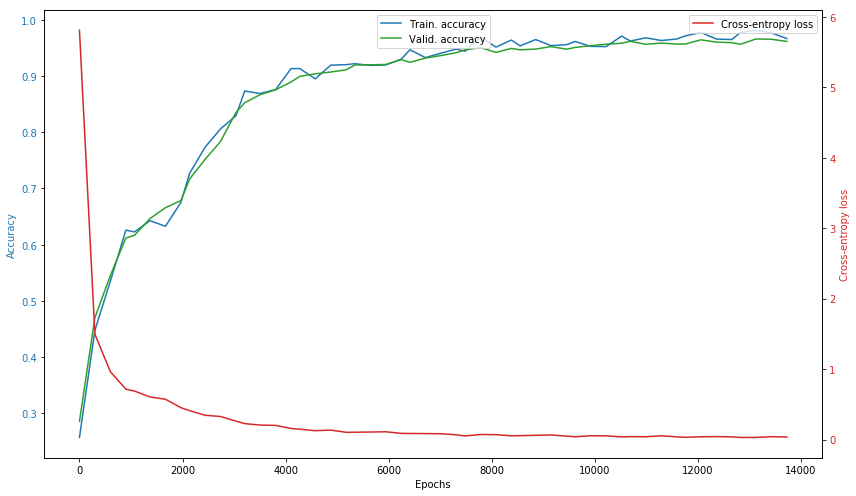

In [68]:
params = load_params()

get_y_vals = lambda d: [d[i] for i in sorted(d)]

valid_accs = get_y_vals(params["valid_accs"])
loss_valus = get_y_vals(params["loss_valus"])
loss_valus = params["loss_valus"]
xticks = sorted(params["loss_valus"])
loss_valus = get_y_vals(loss_valus)

fig, ax1 = plt.subplots(figsize=(12,7))

color = 'tab:blue'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color=color)

ax1.plot(xticks, train_accs, color=color)
ax1.plot(xticks, valid_accs, color='tab:green')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Cross-entropy loss', color=color)
ax2.plot(xticks, loss_valus, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(['Train. accuracy', 'Valid. accuracy'], loc='upper center')
ax2.legend(['Cross-entropy loss'])
fig.tight_layout()  # otherwise the right y-label is slightly clipped

### Translation checking!

In [69]:
(src_text_ids, tar_text_ids),\
(src_w2id, tar_w2id),(src_id2w, tar_id2w) = load_preprocess()

In [155]:
def translate(text, params_path='params.p', language="english"):
    params = load_params(params_path)

    load_path = params["load_path"]
    batch_size = params["batch_size"]

    (src_text_ids, tar_text_ids), \
    (source_w2id, tar_w2id), (source_id2w, tar_id2w) = load_preprocess()

    tokenizer = nltk.data.load('tokenizers/punkt/{}.pickle'.format(language))

    raw_sentences = tokenize_sentences(sentence_to_wordlist, tokenizer.tokenize(text.lower()))
    num_sentences = len(raw_sentences)
    
    raw_sentences += [[""]]*(batch_size-num_sentences)

    input_sentence_ids = lists_of_ids(raw_sentences, source_w2id)
    input_sentence_ids = np.array(pad_sentence_batch(input_sentence_ids, source_w2id["<PAD>"]))
    
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:
        loader = tf.train.import_meta_graph(load_path + ".meta")
        loader.restore(sess, load_path)

        inputs = loaded_graph.get_tensor_by_name("inputs:0")
        logits = loaded_graph.get_tensor_by_name("predictions:0")
        target_sequence_length = loaded_graph.get_tensor_by_name("target_sequence_length:0")
        keep_prob = loaded_graph.get_tensor_by_name("dropout_keepprob:0")
        
        tsl = [len(s) for s in input_sentence_ids]
        # target_sequence_length is set to 2x the len of the source sentence to assure the translation fits in
        translate_logits = sess.run(logits, {inputs:input_sentence_ids,
                                             target_sequence_length: tsl,
                                             keep_prob: 1.0
                                             })
    translated_ids = translate_logits[:num_sentences]
    return ". ".join([" ".join([tar_id2w[w] for w in sen]) for sen in translated_ids])


In [156]:
input_sentence = "I love french. it is a nice language."
translated_sentence = translate(input_sentence)
print("EN:", input_sentence)
print("FR: ", translated_sentence)

INFO:tensorflow:Restoring parameters from checkpoints/dev
EN: I love french. it is a nice language.
FR:  nous aimons les raisins et. la france est la neige
